# First we load in the data


In [9]:
import numpy as np    
import scipy.io as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


#Setting up with fluid flow data
fluid_data = sp.loadmat('cylALL.mat')

velocity_data = fluid_data['UALL']
n = int(fluid_data['n'][0][0])
m = int(fluid_data['m'][0][0])

velocity_data_reshaped = np.reshape(velocity_data, (n, m, 151), order='C').T

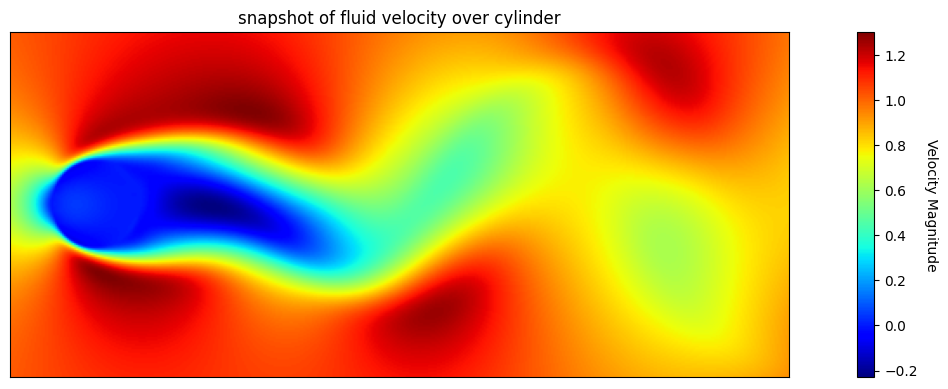

In [10]:
#removing the y and x label ticks
fig,ax = plt.subplots(figsize = (14,4))
plt.title('snapshot of fluid velocity over cylinder')
cbar = plt.colorbar(ax.imshow(velocity_data_reshaped[150,:,:],cmap='jet'))
cbar.set_label('Velocity Magnitude', rotation=270, labelpad=15)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()


# Initialize all the SHRED stuff


In [5]:
from pyshred import DataManager, SHRED, SHREDEngine, DeviceConfig

manager = DataManager(
    lags = 12,
    train_size= 0.8,
    val_size = 0.1,
    test_size = 0.1    
)

manager.add_data(
    data = velocity_data_reshaped,
    id = 'u_velocity',
    random = 3,
    compress = False
)

train_dataset, val_dataset, test_dataset= manager.prepare()
DeviceConfig(device_type = 'cuda') # Set up device to use GPU

shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)


# Training


In [6]:
val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=140,
    batch_size= 32,
    verbose = True,
    lr = 0.0004,
    patience = 100
)

Fitting SHRED...
Epoch 1: Average training loss = 0.346389
Validation MSE (epoch 1): 0.336285
Epoch 2: Average training loss = 0.326961
Validation MSE (epoch 2): 0.308554
Epoch 3: Average training loss = 0.293086
Validation MSE (epoch 3): 0.263742
Epoch 4: Average training loss = 0.241013
Validation MSE (epoch 4): 0.201378
Epoch 5: Average training loss = 0.175710
Validation MSE (epoch 5): 0.137567
Epoch 6: Average training loss = 0.130000
Validation MSE (epoch 6): 0.132387
Epoch 7: Average training loss = 0.137181
Validation MSE (epoch 7): 0.127249
Epoch 8: Average training loss = 0.120893
Validation MSE (epoch 8): 0.115840
Epoch 9: Average training loss = 0.114755
Validation MSE (epoch 9): 0.119312
Epoch 10: Average training loss = 0.117221
Validation MSE (epoch 10): 0.120636
Epoch 11: Average training loss = 0.117053
Validation MSE (epoch 11): 0.118406
Epoch 12: Average training loss = 0.115128
Validation MSE (epoch 12): 0.117201
Epoch 13: Average training loss = 0.114870
Validation

# Downstream tasks

In [7]:
engine = SHREDEngine(manager, shred) #Initialize the SHRED engine used for downstream tasks

# obtain latent space of test sensor measurements
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

# generate latent states from validation sensor measurements
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)

# decode latent space generated from sensor measurements (generated using engine.sensor_to_latent())
test_reconstruction = engine.decode(test_latent_from_sensors)

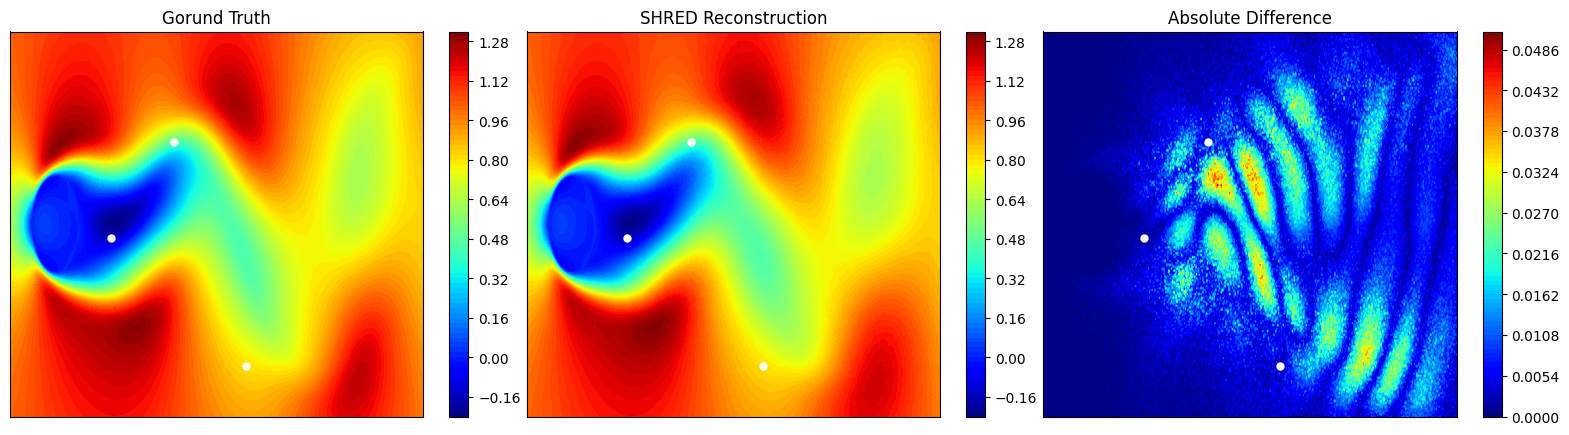

In [8]:
h = len(manager.test_sensor_measurements) # Prediction horizon

sensor_loc = manager.sensor_summary_df['loc/traj'].values
# print(f"Sensor locations (x,y): {sensor_loc}")

# The first reconstructions are not good because the meassurements are padded with zeros. So when you are far enough into the "future" to match your lags 
# you can start evaluating the reconstructions
h = len(manager.test_sensor_measurements)  # Prediction horizon
index = (-1)  # Index of the final frame in the test set (considering lags) 
# Final ground truth frame from the test set
truth = velocity_data_reshaped[index]

# Extract final reconstructed frame (from sensor-based latents)
reconstructions = test_reconstruction["u_velocity"]
reconstruction = reconstructions[index]


# Create side-by-side comparison plot
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# First subplot: SHRED Reconstruction
cf0 = ax[0].contourf(truth, levels=100, cmap='jet')
ax[0].set_title('Gorund Truth')
fig.colorbar(cf0, ax=ax[0])
ax[0].set_xticks([])  # Remove x ticks
ax[0].set_yticks([])  # Remove y ticks

cf0 = ax[1].contourf(reconstruction, levels=100, cmap='jet')
ax[1].set_title('SHRED Reconstruction')
fig.colorbar(cf0, ax=ax[1])
ax[1].set_xticks([])  # Remove x ticks
ax[1].set_yticks([])  # Remove y ticks

# Second subplot: Absolute Difference
cf1 = ax[2].contourf(abs(truth - reconstruction), levels=100, cmap='jet')
ax[2].set_title('Absolute Difference')
fig.colorbar(cf1, ax=ax[2])
ax[2].set_xticks([])  # Remove x ticks
ax[2].set_yticks([])  # Remove y ticks

# Plot sensor locations on both subplots
for y, x in sensor_loc:
    ax[0].plot(x, y, markersize=5, color='white', marker='o')
    ax[1].plot(x, y, markersize=5, color='white', marker='o')
    ax[2].plot(x, y, markersize=5, color='white', marker='o')


# Reduce space between subplots
plt.subplots_adjust(wspace=0)  # Decrease horizontal spacing (default is 0.2)
